## GANRED: GANRED: GAN-based Reverse Engineering of DNNs via Cache Side-Channel + TrustZone

### Abstract

[Робота](https://eprint.iacr.org/2020/1014.pdf) пропонує доведений мат-метод виявлення архітектури скомпільованої нейронної мережі використовуючи L3 кеш. 

VDNN - victim's deep neural network
ADNN - attacker's deep neural network
Prime+Probe - атака на L3 кеш

Скомпільована VDNN за припущенням працює окремим процесом на якомусь сервері, доступу до неї нападник не має. До того ж, оскільки L3 кеш є спільним для всіх процесорів комп'ютера (а не тільки ядер), нейронка може працювати на окремій віртуальній машині (як наприклад на Amazon серверах). Як стверджують автори, нападнику достатньо лиш запустити без прав супер'юзера пропонований GANRED скрипт, маючи тільки доступ до АРІ фреймворка, на якому реалізована цільова нейронна мережа, щоб за ~40 годин (залежить від к-ті шарів) побудувати таку ж.

Дана робота має за ціль реалізувати пропоновану атаку (оскільки ні коду, ні посилання на гітхаб не було) і спробувати адаптувати її для TrustZone.


### 1. Prerequisite

Моніторимо роботу forward propagation VDNN аналізуючи L3 кеш атакою prime+probe. Достатньо
аналізувати якийсь блок, оскільки при роботі великої глибокої нейронки
кеш використовується майже рівномірно. Необхідно зробити кільканадцять
'трейсів' по $p$ проб, де проба = к-ть промахів в кеші. Проблеми:
  - треба якийсь триггер, який реагує на запуск forward propagation,
  оскільки нам треба відділяти різні запуски (інакше побудована нейронка буде в рази глибшою).
  Наприклад - коли людина починає сканити своє обличчя для розблокування.
  - не ясно, чи можна таким чином отримати доступ до кешу траст зони


### 2. GANRED algo

Маючи набір трейсів запускаємо GANRED. Алгоритм:
  1. Ініціалізуємо порожню нейронку.
  2. При підібраних $i$ шарах нейронки перебираємо всі можливі конфігурації $i+1$-го шару
        - обраний шар додаємо до побудованої моделі
        - запускаємо модель з __рандомними__ вагами на __рандомних__ даних і так само
          моніторимо зміну кешу, отримуємо такі-ж трейси, як для VDNN
        - запускаємо __дискримінатор__: знаходимо $L_2$ норму різниці наших трейсів і
            трейсів VDNN, видаємо вектор цих різниць $R = (r_1, r_2, ... r_p)$
        - $k_i^*$ - найбільше таке $k$, що $r_k < \eta$ ($\eta$ - строго визначене і математично доведене)
        - якщо це $k_i^*$ більше, ніж попереднє, то схоже на те, що ми підібрали
          правильні параметри.
        - запускаємо __валідатор__: додатково порівнюємо теоретичний час роботи підібраного
          шару з реальним для VDNN, використовуючи лінійну регресію, щоб уникнути
          помилки False-Positive.

Проблеми:
  - час роботи в авторських експериментах ~40 годин для VGG з 16 шарів на Intel i7700 CPU.
    Складність часу роботи - лінійна, але константа == декілька годин, отже на кожен
    лишній шар буде 2-3 години лишньої роботи. Для умовного ResNet-50 це буде порядка 100
    годин роботи на Intel i7700, на якомусь нещасному мікроконтролері страшно уявити
  - необхідний доступ до високорівного API фреймворка, на якому написана VDNN (наприклад TensorFlow).
    Якщо нейронка буде реалізована в трастлеті, то це буде плейн С код. Не ясно
    чи будуть тоді трейси ADNN схожими на VDNN при такій реалізації.
  - пропонована атака може бути застосовна лиш до моделей з __лінійною__ архітектурою, які використовують повнозв'язні шари і 2-д конволюції (насправді там набагато більше обмежень, див __attack_stuff.py__)


## Results
  
Вдалось перевірити коректність запропонованого __дискримінатора__ і частково реалізувати весь GANRED. Однак,
базуючись на даних, отриманих експериментальним шляхом, ми ніяк не можемо вважати істинним твердження з роботи: 

```The validator estimates thetheoretical running time of a layer with parameters 𝜃𝑙 based on the following observation: the execution time of a layer is linear in both its number of multiply-and-accumulate (MAC) operations and the number of cache misses```

Таким чином, лінійна регресія, запропонована в роботі, не може бути використана для реалізації валідатора, а отже **ми не можемо** повністю відтворити фреймворк, запропонований в роботі. Автори стверджують про лінійність залежності часу роботи від деяких параметрів шару не наводячи жодних доказів, на відміну від інших тверджень. В роботі математично доведено, що шари з однаковою структурою даватимуть схожі сліди в L3 кеші ($L_2$ відстань між ними можна обмежити дуже малим числом), однак у випадку з валідатором ситуація прямо протилежна. В роботі про нього написано мінімальну к-ть інформації, а крім графіків незрозуміло яких експериментів нема жодних доказів правильності їх твердження (код їхнього фреймворка відсутній, жодних посилань на гітхаб чи щось схоже нема). До того ж, запропоновані формули обчислення к-ті MAC операцій і промахів в кеші __не коректні__, замість них було виведено нові (див. __attack_stuff.py__)

Можливі декілька варіантів вирішення цієї проблеми:
  1. Заміна лінійної регресії на невелику нейронку, однак для її навчання необхідно буде більше даних, а отже
     час попередньої роботи збільшиться
  2. Замість статистичної перевірки у валідаторі (регресія, нейронка) робити перевірку експериментальним
     шляхом (типу запускати тестову модель з вибраним шаром і перевіряти час роботи). Однак такий варіант
     портувати на траст зону в рази складніше.

# Execution time experiments for Convolutional layers

In [2]:
from attack_stuff import possible_layers, Pool, Conv, TFv2_Conv    # my module with stuff for GANRED
from collections import Counter  
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import logging
import numpy as np

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

logging.disable(logging.WARNING)

shape = [1024, 1024, 3]

random = tf.constant(np.random.random(size=[1]+shape))   # random data for testing ADNN


def possible_layers(input_shape):          # some possible Convolutional layers of DNN
    for filter_width in range(3, 20):
        for stride in range(3, 12):
    
            for filters in range(1, 128): # 64, 128, 256, 512, 1024, 2048]:
                for padding in ['same', 'valid']:
                    yield TFv2_Conv(width_in=input_shape[0],
                                    depth_in=input_shape[1],
                                    depth_out=filters,
                                    filter_width=filter_width,
                                    stride=stride,
                                    padding=padding)

# values of paramateres which is hypothetical linear base for execution time                   
parameters = [layer.linear_parameters() for layer in possible_layers(shape)]
print(len(parameters))
Counter([layer.mac() for layer in possible_layers(shape)]).most_common(10)

38862


[(100859904, 18),
 (50429952, 17),
 (151289856, 17),
 (201719808, 17),
 (89653248, 17),
 (134479872, 16),
 (179306496, 16),
 (268959744, 16),
 (113467392, 15),
 (315187200, 15)]

## Not using offense time for compilation

In [1]:
times = []

inputs = tf.keras.layers.Input(shape)
for i, layer in enumerate(possible_layers(shape)):
    if not isinstance(layer, Conv):
        continue
    tmp_x = layer.generate()(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=tmp_x)
    model.compile()
    
    t = get_time1()             
    model.predict(random)
    res_t = get_time1() - t    # here we get full time for prediction (including possible tf compilation time )
    times.append(res_t)
    print('\r' * 1000, end='')
    print(f'model {i} of {len(parameters)}, executed in {res_t}s', end='')
    
    if not i & ((1 << 10) - 1): 
        with open('times_output.txt', 'w') as file:
            file.write(str(times))
        print(f'\n\n[=>] Writing {i} times to file.\n')

<IPython.core.display.Javascript object>


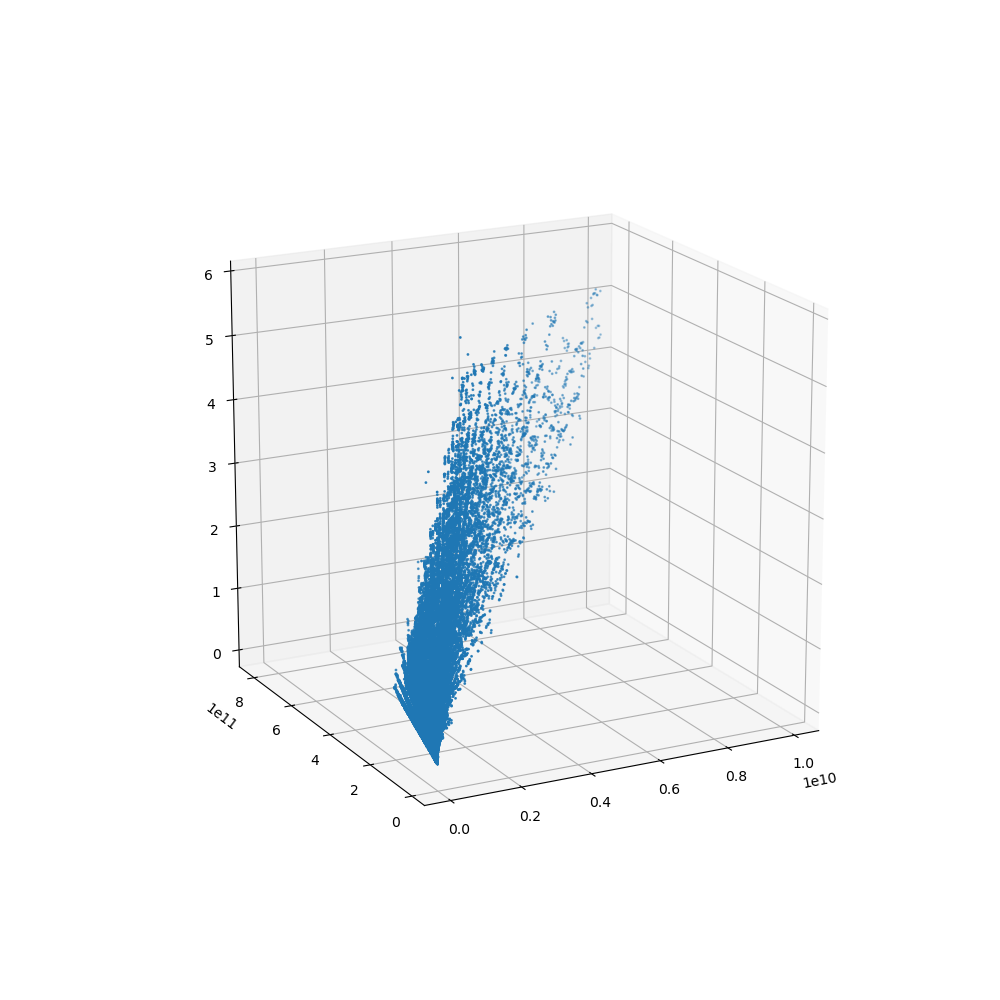

In [18]:
n = len(times)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(parameters[:n], times[:n])

According to information from [paper](https://eprint.iacr.org/2020/1014.pdf): 

```The validator estimates thetheoreticalrunning time of a layerwith parameters 𝜃𝑙 based on the following observation: the execution time of a layer is linear in both its number of multiply-and-accumulate(MAC) operations and the number of cache misses.```

Therefore, experiment data for convolutional layer should look like this: 

![plane](./graphs/plane.png)

Although, as we can see on the previous plot, these data have **non-linear** structure. Here some other foreshorteringhs as a proof: 

![shot1](./graphs/foreshortering1.jpg)

![shot2](./graphs/foreshortering2.jpg)

![shot3](./graphs/foreshortering3.jpg)

## Using offense for compilation

In [5]:
def possible_layers(input_shape):     # another set of possible Conv layers
    for filter_width in [3, 5, 7]:
        for stride in [1, 2]:

            for filters in [8, 16, 32, 64]: # 64, 128, 256, 512, 1024, 2048]:
                for padding in ['same', 'valid']:
                    yield TFv2_Conv(width_in=input_shape[0],
                                    depth_in=input_shape[1],
                                    depth_out=filters,
                                    filter_width=filter_width,
                                    stride=stride,
                                    padding=padding)
                    

parameters = [layer.linear_parameters() for layer in possible_layers(shape)]
print(len(parameters))
                    
inputs = tf.keras.layers.Input(shape) 
model = tf.keras.models.Model(inputs=inputs, outputs=inputs)
model.compile()
t = get_time1()
model.predict(random)
global_time = get_time1() - t               # offense for compilation time 
                    
times = []

for i, layer in enumerate(possible_layers(shape)):
    if not isinstance(layer, Conv):
        continue
    tmp_x = layer.generate()(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=tmp_x)
    model.compile()
    
    t = time.time()
    model.predict(random)
    res_t = time.time() - t
    times.append(res_t - global_time)   # subtract offense for compilation
    print('\r' * 1000, end='')
    print(f'model {i} of {len(parameters)}, executed in {res_t}s', end='')

48
model 47 of 48, executed in 0.7962641716003418ss

## Again, non-linear structure

<IPython.core.display.Javascript object>


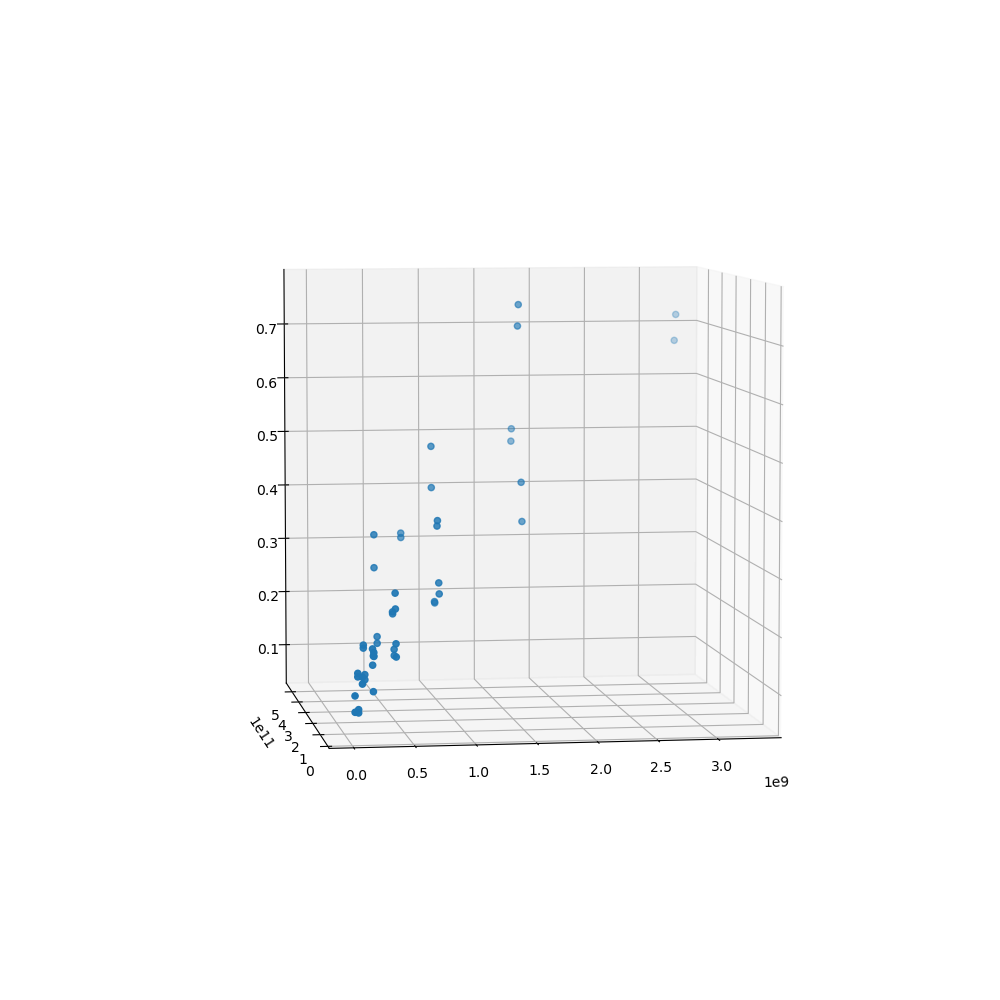

In [9]:
x = [par[0] for par in parameters]
y = [par[1] for par in parameters]

n = len(times)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:n], y[:n], times[:n])

## Monte-Carlo 

Here we observe some random layers instead of determined.

In [ ]:
def random_layers(input_shape, amount=1000):
    # TODO: rewrite it without such amount of cycles
    
    for _ in range(amount):
        filter_width = np.random.randint(3, 100)
        stride = np.random.randint(1, filter_width)
        filters = np.random.randint(10, 200)
        padding = np.random.choice(['same', 'valid'])
        yield TFv2_Conv(width_in=input_shape[0],
                        depth_in=input_shape[1],
                        depth_out=filters,
                        filter_width=filter_width,
                        stride=stride,
                        padding=padding)


inputs = tf.keras.layers.Input(shape) 
model = tf.keras.models.Model(inputs=inputs, outputs=inputs)
model.compile()
t = time.time()
model.predict(random)
global_time = time.time() - t
                    
times = []
parameters = []

for i, layer in enumerate(random_layers(shape)):
    if not isinstance(layer, Conv):
        continue
    tmp_x = layer.generate()(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=tmp_x)
    model.compile()
    
    t = time.time()
    model.predict(random)
    res_t = time.time() - t
    times.append(res_t - global_time)
    parameters.append(layer.linear_parameters())
    print('\r' * 1000, end='')
    print(f'model {i} of {len(parameters)}, executed in {res_t}s', end='')

model 1 of 2, executed in 2.2359836101531982s

In [3]:
np.random.randint(3, 100)

76

## Random convs with activation RELU 

In [1]:
import pickle 

with open('parameters.dav', 'rb') as file:
    x, y = pickle.load(file)

with open('times.dav', 'rb') as file:
    times = pickle.load(file)


Again, **non-linear**

<IPython.core.display.Javascript object>


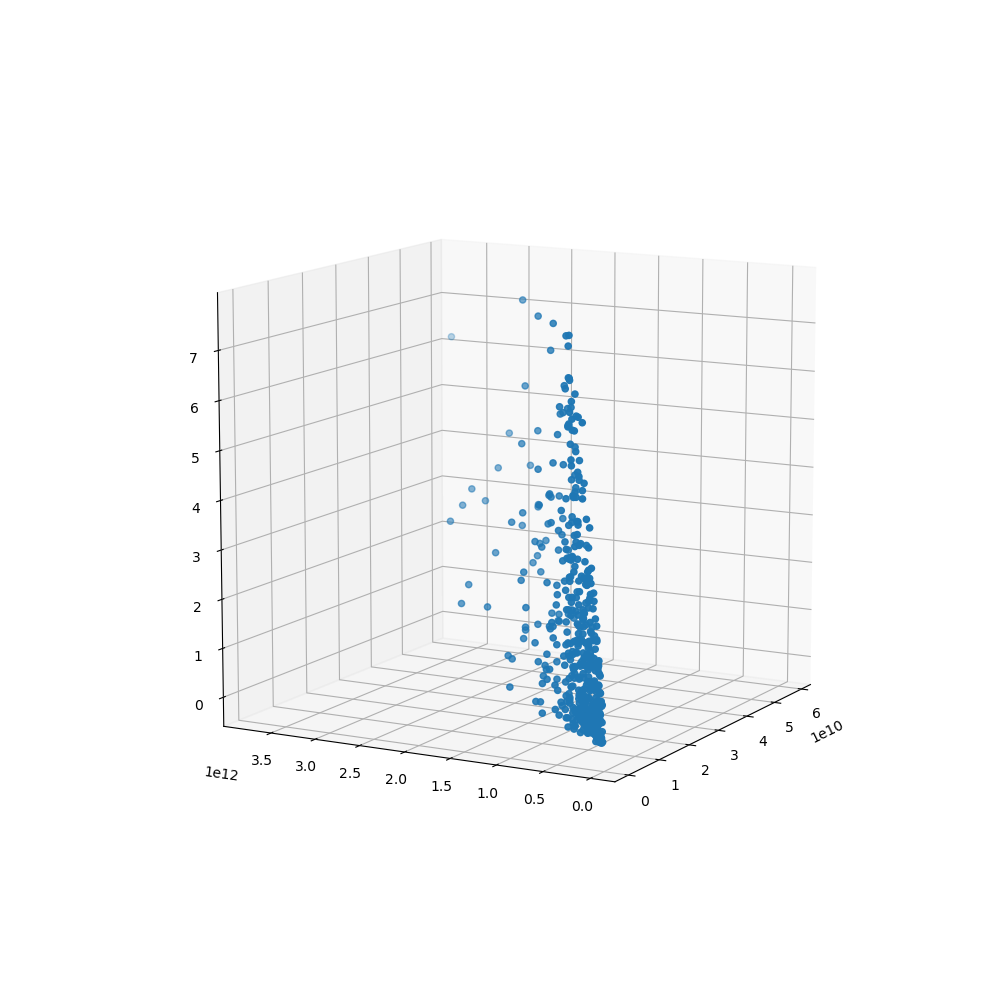

In [3]:
n = len(times)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:n], y[:n], times[:n])

## Random convs without RELU

In [4]:
with open('parameters_relu_less.dav', 'rb') as file:
    x, y = pickle.load(file)

with open('times_relu_less.dav', 'rb') as file:
    times = pickle.load(file)

Again, **non-linear**

<IPython.core.display.Javascript object>


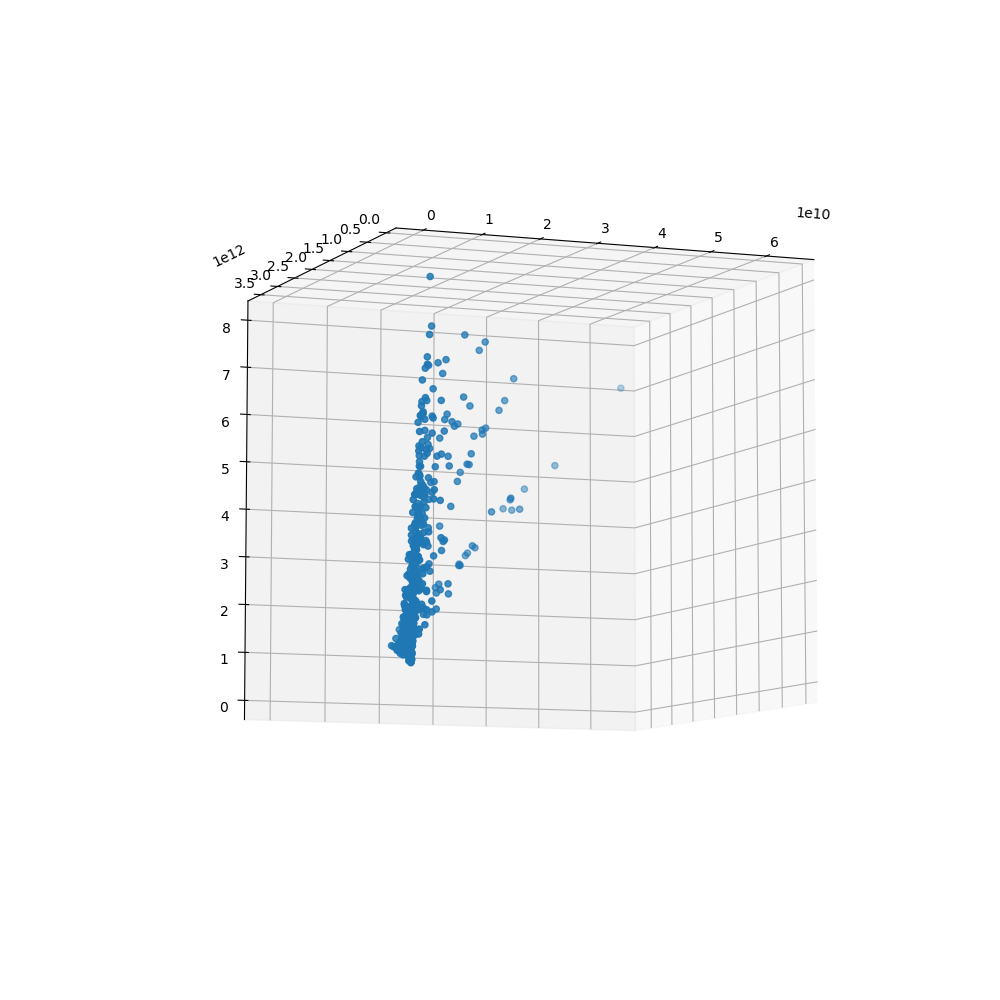

In [5]:
n = len(times)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:n], y[:n], times[:n])